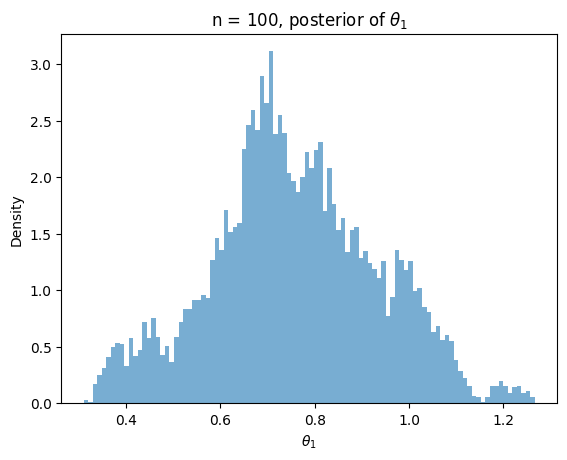

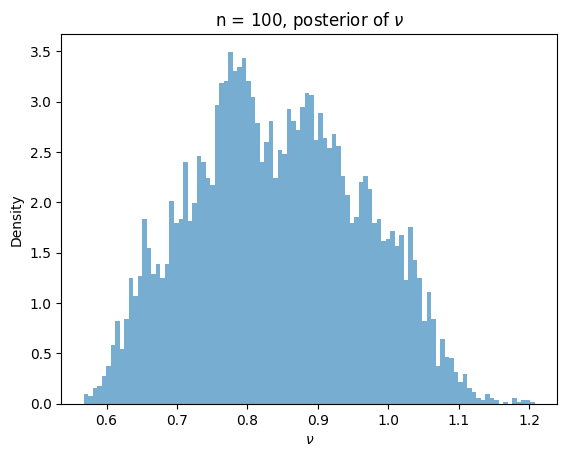

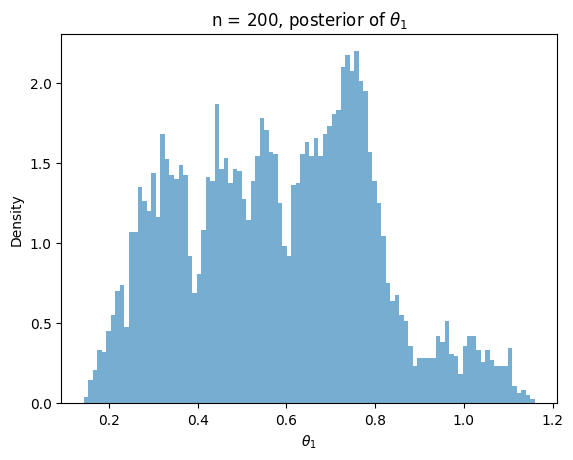

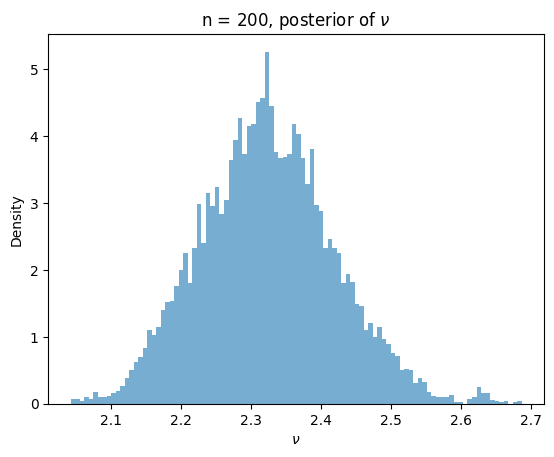

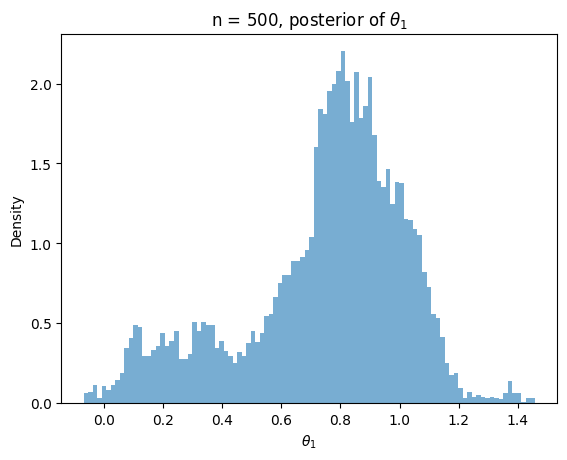

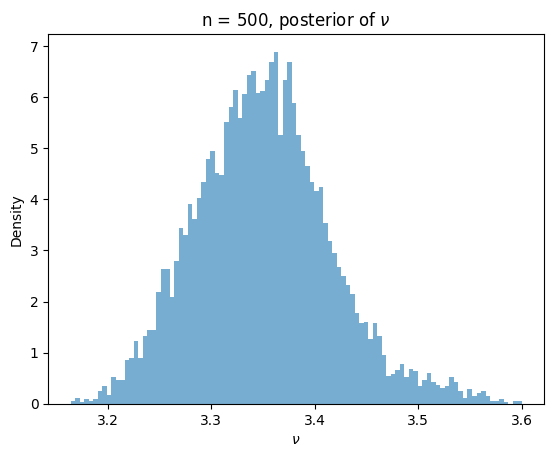

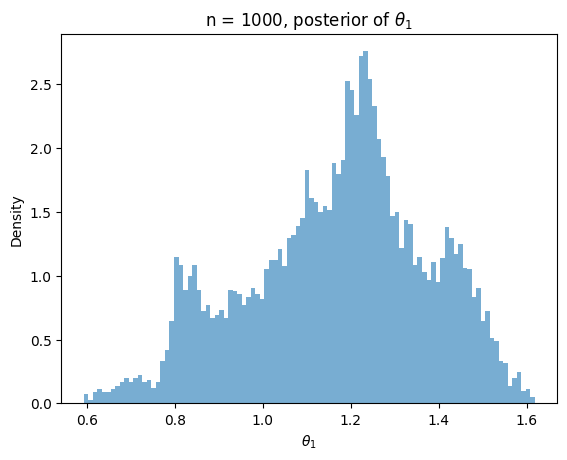

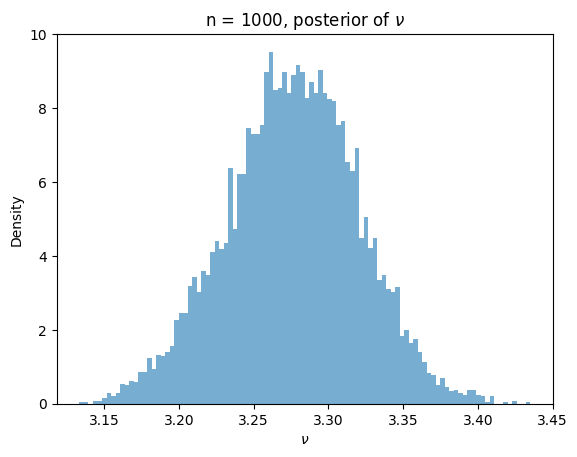

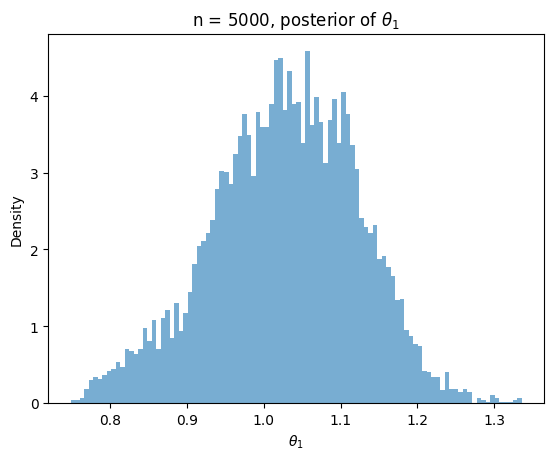

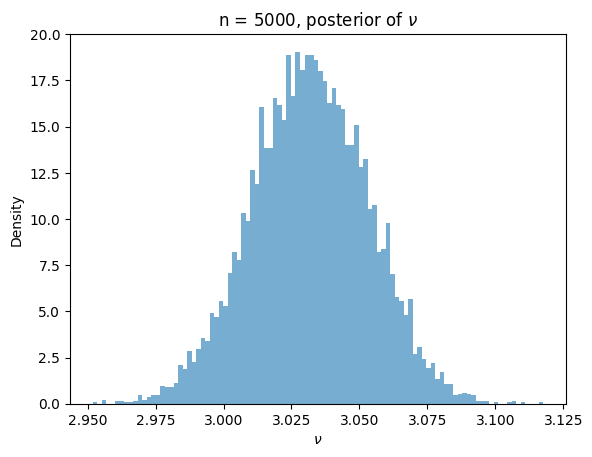

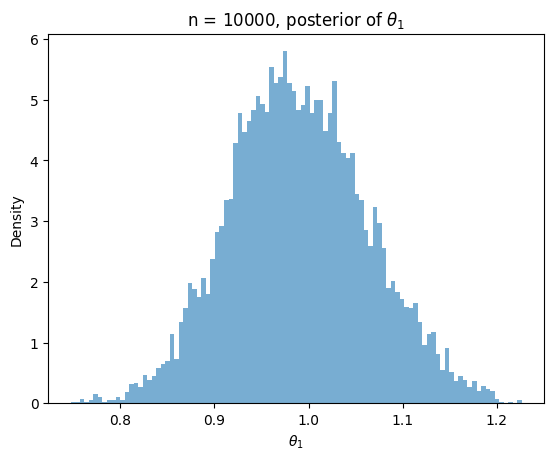

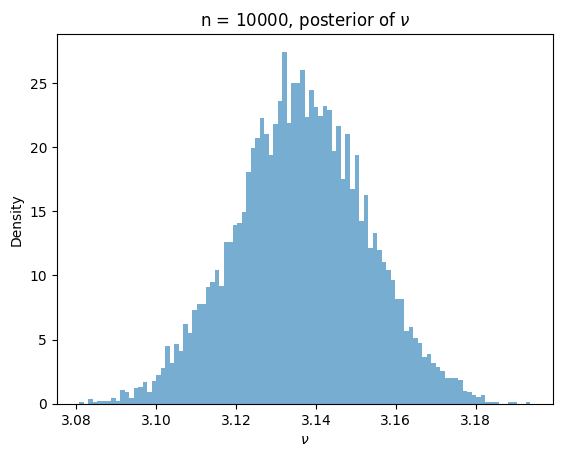

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def make_dirichlet_laplacian_basis(p):
    e_funcs = []
    for j in range(p):
        def basis_fn(x, j=j):
            return np.sin((j+1) * np.pi * (x + 1) / 2)
        e_funcs.append(basis_fn)
    return e_funcs



#log-likelihood function of l(theta|X,Y)
def log_likelihood(theta, nu, X, Y):
    sigma = np.sqrt(np.exp(nu))
    X = np.asarray(X)
    Y = np.asarray(Y)
    theta = np.asarray(theta)
    n = X.shape[0]

    # Build design matrix Phi
    e_funcs = make_dirichlet_laplacian_basis(len(theta))
    Phi = np.vstack([f(X) for f in e_funcs]).T  # shape (n, p)

    # residuals
    residuals = Y - Phi.dot(theta)

    ll_uniform = - n * np.log(2)
    ll_norm = - (n/2) * np.log(2 * np.pi * sigma**2)
    ll_quad= - np.sum(residuals**2) / (2 * sigma**2)

    return ll_uniform + ll_norm + ll_quad




def design_matrix(X, p):
    e_funcs = make_dirichlet_laplacian_basis(p)
    return np.vstack([f(X) for f in e_funcs]).T

# grad log-likelihood  
def grad_log_likelihood_theta_nu(theta, nu, X, Y):
    n = X.shape[0]
    Phi = design_matrix(X, theta.shape[0])
    r = Y - Phi.dot(theta)
    inv_sig2 = np.exp(-nu)
    grad_theta = Phi.T.dot(r) * inv_sig2
    S = (r/n).dot(r/n)
    grad_nu = -0.5*n + 0.5*S * inv_sig2 * (n**2)
    return np.concatenate([grad_theta, [grad_nu]])

#grad log prior of N(0,Sigma^-1), Sigma = (1,2^a,3^a,4^a,...)
def grad_log_prior(theta, nu, alpha, n):
    p = theta.shape[0]
    sigma = 1.0    #no rescaling prior
    weight_theta = np.array([(j+1)**(2*alpha) for j in range(p)])
    grad_theta = -sigma * weight_theta * theta
    grad_nu = -sigma * nu
    return np.concatenate([grad_theta, [grad_nu]])

def unadjusted_langevin(X, Y, theta_init, nu_init, gamma, N, alpha):
    p = theta_init.shape[0]
    v = np.concatenate([theta_init, [nu_init]]).astype(float)
    chain = np.zeros((N+1, p+1))
    chain[0] = v
    for t in range(N):
        score = grad_log_likelihood_theta_nu(v[:p], v[p], X, Y)
        score += grad_log_prior(v[:p], v[p], alpha, X.shape[0])
        v = v + gamma*score + np.sqrt(2*gamma)*np.random.randn(p+1)
        chain[t+1] = v
    return chain

######Varying number of samples#####
p = 4
alpha = 1
gamma = 1e-4
N = 10000
n_values = [100,200,500,1000,5000,10000]

# generate true θ once
t = 50
np.random.seed(20)
theta_true = np.ones(t)

# generate full dataset once
n_max = max(n_values)
X_full = np.random.uniform(-1, 1, size=n_max)
Phi_full = design_matrix(X_full, t)
a = np.random.randn(n_max)
Y_full = Phi_full.dot(theta_true) + a
 
# loop over sample sizes
results = []   #gives MSE
results_no_nu = []   #gives MSE excluding nu - this is what we use
results_mean = []   #posterior mean
results_var = []   #marginal variance, in particular 
for n in n_values:
    X = X_full[:n]
    Y = Y_full[:n]

    #print(burn_in)

    burn_in = 2000
    theta_init = np.zeros(p)
    nu_init = 0
    chain = unadjusted_langevin(X, Y, theta_init, nu_init, gamma, N, alpha)

    # discarding burn-in
    samples = chain[burn_in:]
    theta_samples = samples[:, :p]
    nu_samples    = samples[:,  p]

    # empirical posterior mean & MSE
    post_mean = theta_samples.mean(axis=0)
    post_mean_nu = nu_samples.mean(axis=0)
    mse = np.mean((post_mean - theta_true[:p])**2 + (post_mean_nu)**2)
    mse_no_nu = np.mean((post_mean - theta_true[:p])**2 )
    var_theta = np.var(theta_samples, axis=0, ddof=1)
    results.append({'n': n, 'mse': mse})
    results_no_nu.append({'n': n, 'mse': mse_no_nu})
    results_mean.append({'n': n, 'Post_mean': [post_mean,post_mean_nu]})
    results_var.append({'n': n, 'Post_var': var_theta})


    # sketch marginal of θ₀
    plt.figure()
    plt.hist(theta_samples[:,0], bins=100, density=True, alpha=0.6)
    plt.title(f"n = {n}, posterior of $θ_1$")
    plt.xlabel(r"$\theta_1$")
    plt.ylabel("Density")
    plt.show()

    plt.figure()
    plt.hist(nu_samples[:], bins=100, density=True, alpha=0.6)
    plt.title(f"n = {n}, posterior of $\\nu$")
    plt.xlabel(r"$\nu$")
    plt.ylabel("Density")
    plt.show()
    #print(chain)

# display MSE vs n
df = pd.DataFrame(results)
df2 = pd.DataFrame(results_no_nu)
df3 = pd.DataFrame(results_mean)



In [91]:
results_var

[{'n': 100,
  'Post_var': array([0.03152238, 0.03123901, 0.03516336, 0.0222048 ])},
 {'n': 200,
  'Post_var': array([0.04585174, 0.08696053, 0.03412223, 0.02614822])},
 {'n': 500,
  'Post_var': array([0.07676638, 0.05353296, 0.07577076, 0.04616537])},
 {'n': 1000,
  'Post_var': array([0.04169216, 0.07173528, 0.04869919, 0.02624524])},
 {'n': 5000,
  'Post_var': array([0.00910152, 0.00834292, 0.00762223, 0.00650525])},
 {'n': 10000,
  'Post_var': array([0.00535963, 0.00396619, 0.00395633, 0.00390013])}]

In [92]:
results_mean

[{'n': 100,
  'Post_mean': [array([0.7566603 , 0.30151108, 0.62698876, 0.12341579]),
   np.float64(0.8436998807142639)]},
 {'n': 200,
  'Post_mean': [array([0.58265764, 0.54780272, 0.30692083, 0.22167597]),
   np.float64(2.3242310786216627)]},
 {'n': 500,
  'Post_mean': [array([0.74643931, 0.57710493, 0.60099857, 0.32960906]),
   np.float64(3.3507710647969597)]},
 {'n': 1000,
  'Post_mean': [array([1.16951235, 0.94966627, 0.85171965, 0.57699279]),
   np.float64(3.27627164768911)]},
 {'n': 5000,
  'Post_mean': [array([1.02755128, 0.99905538, 0.93587969, 0.91619714]),
   np.float64(3.0318655705760182)]},
 {'n': 10000,
  'Post_mean': [array([0.99006087, 0.99587901, 0.98932659, 0.96232592]),
   np.float64(3.1362860000304056)]}]

In [93]:
results_no_nu

[{'n': 100, 'mse': np.float64(0.3636595617772932)},
 {'n': 200, 'mse': np.float64(0.3662010162203082)},
 {'n': 500, 'mse': np.float64(0.21293985388768247)},
 {'n': 1000, 'mse': np.float64(0.05804752138654257)},
 {'n': 5000, 'mse': np.float64(0.0029735749166504353)},
 {'n': 10000, 'mse': np.float64(0.0004122567723386895)}]

[0.09104629]


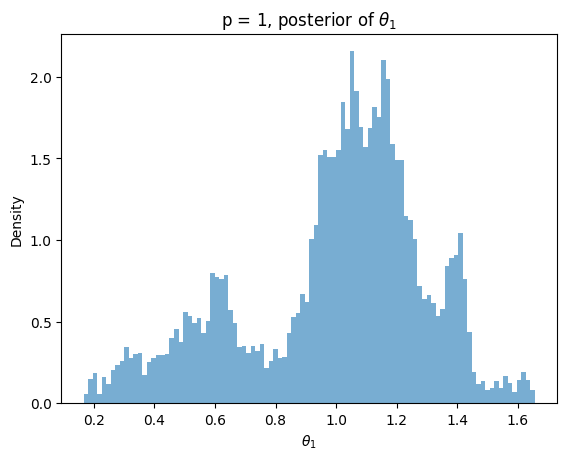

[0.03702244 0.03486834 0.03094003 0.03456304]


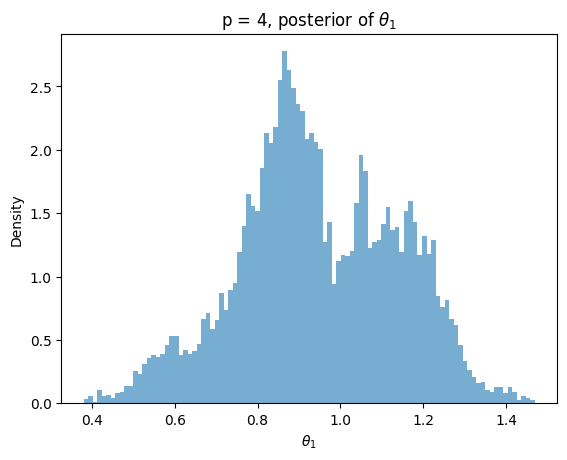

[0.14147637 0.05336546 0.03447635 0.04161765 0.03214289 0.02334875
 0.0186374  0.01345774]


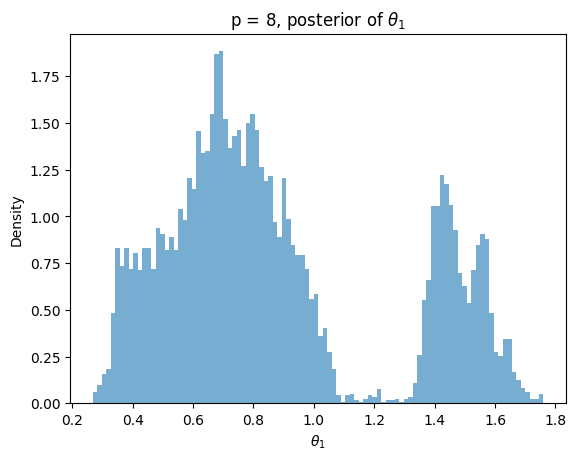

[0.03863991 0.0476753  0.06793511 0.02722169 0.0313711  0.03403037
 0.01838897 0.01555852 0.01065091 0.00757563 0.00688523 0.00821136]


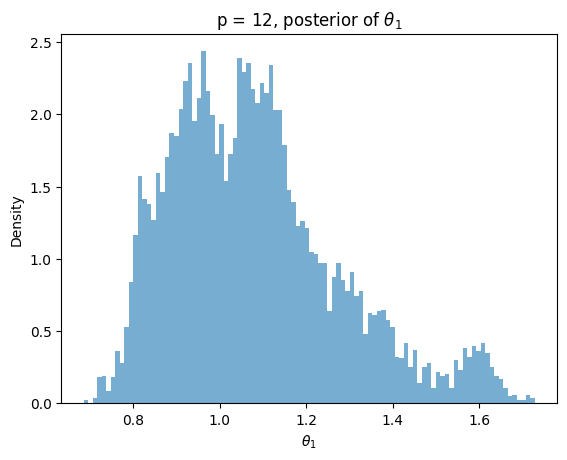

[0.0451872  0.02252131 0.03217068 0.0301067  0.0291748  0.02100677
 0.02139894 0.01529723 0.00926829 0.00863473 0.00669635 0.00541062
 0.00571408 0.00427699 0.00482685 0.00336364]


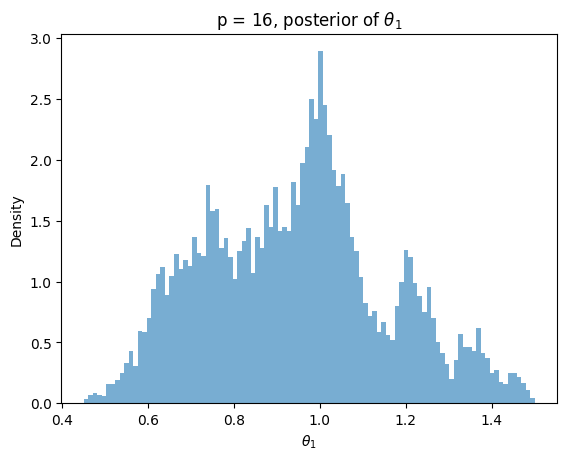

[0.03337399 0.01845548 0.04674162 0.03700373 0.02699147 0.02320133
 0.01464974 0.01400689 0.01222793 0.00904877 0.00785929 0.0070723
 0.0057464  0.00563128 0.0042128  0.00413786 0.00345298 0.00293716
 0.00283927 0.00250514]


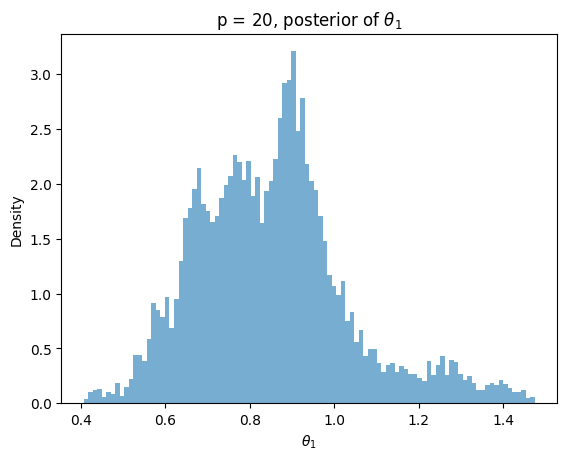

Summary (per p):
    p        mse  mse_no_nu    var_nu  mean_var_theta
0   1  10.319356   0.000007  0.003838        0.091046
1   4  10.290574   0.163811  0.004603        0.034348
2   8  10.230399   0.381632  0.003672        0.044815
3  12  10.272307   0.521361  0.004056        0.026179
4  16  10.306675   0.626558  0.004267        0.016566
5  20  10.399942   0.688179  0.003790        0.014105

MSE without nu (per p):
    p       mse
0   1  0.000007
1   4  0.163811
2   8  0.381632
3  12  0.521361
4  16  0.626558
5  20  0.688179

Per-θ variances (long form):
   p  theta_index  var_theta_j
0  1            1     0.091046
1  4            1     0.037022
2  4            2     0.034868
3  4            3     0.030940
4  4            4     0.034563


In [ ]:
np.random.seed(20)
import numpy as np
import random
##### Varying number of parameters estimated #####
p_values = [1,4,8,12,16,20]
alpha = 1
gamma = 1e-4
N = 10000
n = 500   # fixed sample size

# Once again, true theta once
t = 50
random.seed(1)
theta_true = np.ones(t)

# generate dataset
X_full = np.linspace(-1, 1, n)
Phi_full = design_matrix(X_full, t)
Y_full = Phi_full.dot(theta_true) + np.random.randn(n)


results = []
results_no_nu = []
detailed_var_rows = []  

for p in p_values:
    X = X_full
    Y = Y_full
    burn_in = 2000

    # sample with ULA
    theta_init = np.zeros(p)
    nu_init = 0
    chain = unadjusted_langevin(X, Y, theta_init, nu_init, gamma, N, alpha)

    # discarding burn-in
    samples = chain[burn_in:]
    theta_samples = samples[:, :p]
    nu_samples = samples[:, p]

    # empirical posterior mean
    post_mean = theta_samples.mean(axis=0)
    post_mean_nu = nu_samples.mean()

    # posterior marginal variances
    var_theta = np.var(theta_samples, axis=0, ddof=1)  
    print(var_theta)
    var_nu = np.var(nu_samples, ddof=1)               

    # MSEs
    mse = np.mean((post_mean - theta_true[:p])**2 + (post_mean_nu)**2)
    mse_no_nu = np.mean((post_mean - theta_true[:p])**2)


    results.append({
        'p': p,
        'mse': mse,
        'mse_no_nu': mse_no_nu,
        'var_nu': var_nu,
        'mean_var_theta': float(var_theta.mean())
    })
    results_no_nu.append({'p': p, 'mse': mse_no_nu})


    # sketch marginal of θ₀
    plt.figure()
    plt.hist(theta_samples[:, 0], bins=100, density=True, alpha=0.6)
    plt.title(f"p = {p}, posterior of $θ_1$")
    plt.xlabel(r"$\theta_1$")
    plt.ylabel("Density")
    plt.show()


df = pd.DataFrame(results)
df2 = pd.DataFrame(results_no_nu)
df_theta_var = pd.DataFrame(detailed_var_rows)  # per-θ variances



In [ ]:
# For base case : fixed p = 4 for increasing n
#Fixed N = 10k for increasing p = [4,...,24]

#For 1 param: p = 4, increasing n, nu = 0, nu = 4
# p = [4,...,24], fixed N = 10k, nu = 0

